In [1]:
######################################################################
# Set Up the Environment
######################################################################
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Create a directory to save model and plots
os.makedirs("output", exist_ok=True)

/opt/anaconda3/envs/BeginnerCourse/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/BeginnerCourse/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /opt/anaconda3/envs/BeginnerCourse/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /opt/anaconda3/envs/BeginnerCourse/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:
######################################################################
# Load and Preprocess the MNIST Dataset
######################################################################
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

# Load the dataset
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)
test_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, transform=transform, download=True
)

# Split training data for validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [5]:
train_size, val_size, train_dataset, val_dataset

(48000,
 12000,
 <torch.utils.data.dataset.Subset at 0x1083b8fd0>)

In [ ]:
# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
train_loader, val_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x15d72f820>,
 <torch.utils.data.dataloader.DataLoader at 0x15d72f220>)

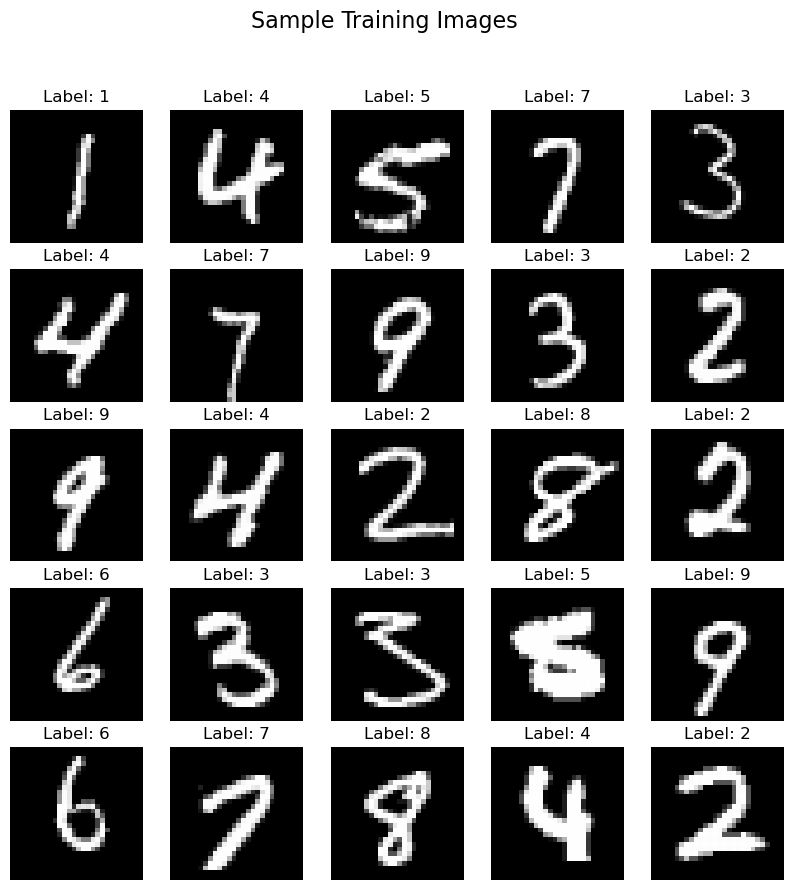

In [ ]:
######################################################################
# Visualize Sample Data
######################################################################
def visualize_samples(dataset):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        img, label = dataset[i]
        img = img.squeeze().numpy()
        plt.subplot(5, 5, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(f"Label: {label}")
        plt.axis("off")
    plt.suptitle("Sample Training Images", fontsize=16)
    plt.savefig("output/sample_training_images.png")
    plt.show()


visualize_samples(train_dataset)

In [ ]:
######################################################################
# Define the Neural Network Model
######################################################################
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MNISTModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
######################################################################
# Train the Model
######################################################################
def train_model(model, train_loader, val_loader, epochs=10):
    train_losses, val_losses = [], []
    best_val_loss = float("inf")
    patience, counter = 10, 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(
            f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
        )

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), "output/mnist_model.pth")
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered")
                break

    return train_losses, val_losses

In [13]:
train_losses, val_losses = train_model(model, train_loader, val_loader)

Epoch 1: Train Loss: 0.4535, Val Loss: 0.2617
Epoch 2: Train Loss: 0.2503, Val Loss: 0.1924
Epoch 3: Train Loss: 0.1979, Val Loss: 0.1558
Epoch 4: Train Loss: 0.1712, Val Loss: 0.1400
Epoch 5: Train Loss: 0.1594, Val Loss: 0.1318
Epoch 6: Train Loss: 0.1444, Val Loss: 0.1180
Epoch 7: Train Loss: 0.1369, Val Loss: 0.1212
Epoch 8: Train Loss: 0.1280, Val Loss: 0.1099
Epoch 9: Train Loss: 0.1202, Val Loss: 0.1179
Epoch 10: Train Loss: 0.1157, Val Loss: 0.1023


In [31]:
plt.style.use("ggplot")

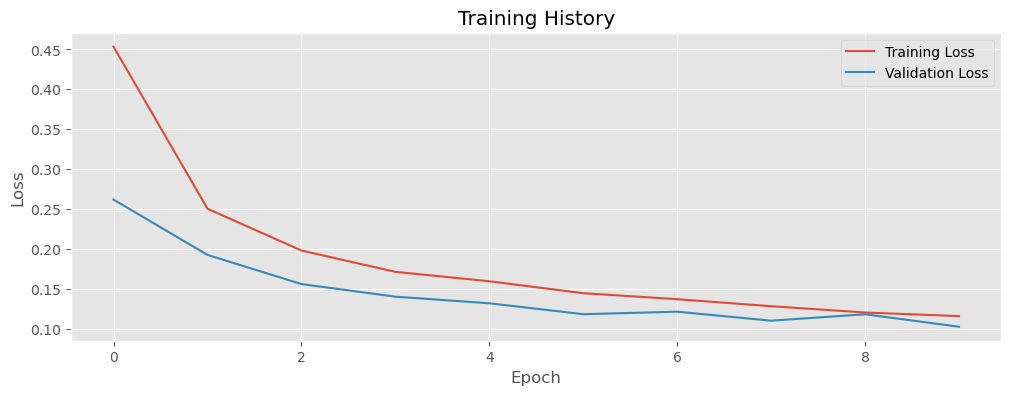

In [27]:
######################################################################
# Plot Training History
######################################################################
plt.figure(figsize=(12, 4))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("output/training_history.png")
plt.show()

In [30]:
######################################################################
# Evaluate the Model
######################################################################
def evaluate_model(model, test_loader):
    model.load_state_dict(torch.load("output/mnist_model.pth"))
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return all_labels, all_preds


labels, preds = evaluate_model(model, test_loader)

/var/folders/b0/0l4ksqs93r57m4lrp4v92c700000gn/T/ipykernel_30267/2186467272.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("output/mnis

Test Accuracy: 97.23%


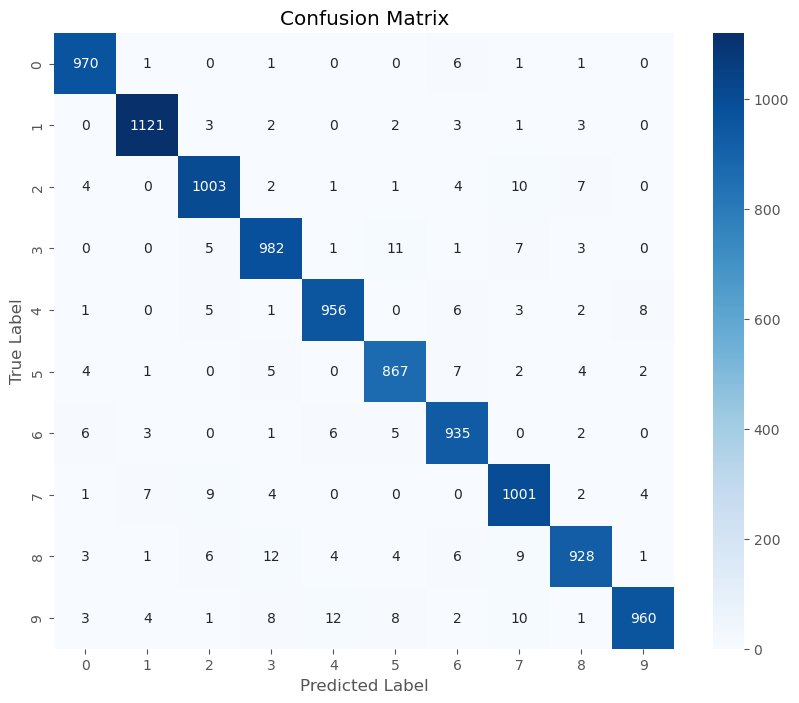

In [28]:
######################################################################
# Confusion Matrix
######################################################################
conf_matrix = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=range(10),
    yticklabels=range(10),
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("output/confusion_matrix.png")
plt.grid()
plt.show()

In [17]:
######################################################################
# Classification Report
######################################################################
print("Classification Report:")
print(classification_report(labels, preds))

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.96      0.97      0.97      1010
           4       0.98      0.97      0.97       982
           5       0.97      0.97      0.97       892
           6       0.96      0.98      0.97       958
           7       0.96      0.97      0.97      1028
           8       0.97      0.95      0.96       974
           9       0.98      0.95      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [18]:
######################################################################
# Save Predictions to CSV
######################################################################
results = pd.DataFrame({"True Label": labels, "Predicted Label": preds})
results.to_csv("output/predictions.csv", index=False)
print("Predictions exported to output/predictions.csv")

Predictions exported to output/predictions.csv
